# Keras-Image-Classification

## Divide OASIS Image datset into :


In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt



import tensorflow as tf
from keras import backend as K
from shutil import copyfile
from shutil import rmtree

from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU, Bidirectional, LSTM
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Masking
from keras.layers.core import  ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.regularizers import L1L2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from sklearn.model_selection import KFold
import os
import io
import numpy as np
import tensorflow as tf
from gensim.models import word2vec
import pandas as pd
# from fastText import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import text
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

from os import listdir
from os.path import isfile, join
from shutil import copyfile
from shutil import rmtree
from sklearn.model_selection import StratifiedKFold
import glob
%matplotlib inline 

import pprint
os.environ["CUDA_VISIBLE_DEVICES"]="1"



# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 2
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

# fix random seed for reproducibility
seed = 7

None


/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data pre-processing and data augmentation

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 

These are just a few of the options available (for more, see the documentation). Let's quickly go over what we just wrote:

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Now let's start generating some pictures using this tool and save them to a temporary directory, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable:

Total Augmented images 21


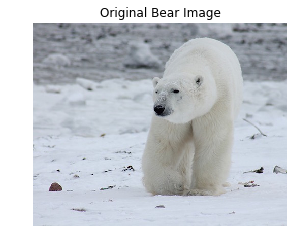

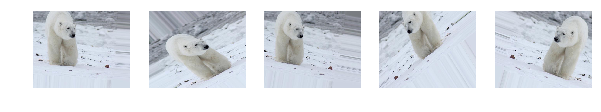

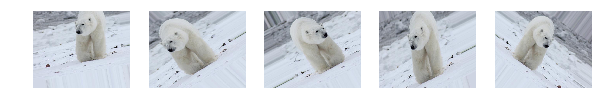

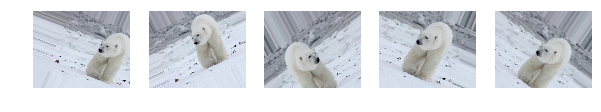

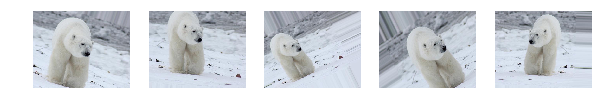

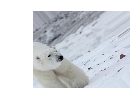

In [ ]:
images_path = "/home/elkhand/git-repos/human-emotions-classifier/dataset/images/"
bear_image_path = images_path + "Bear 3.jpg"

augmented_images_path = "/home/elkhand/git-repos/human-emotions-classifier/preview/"

augmented_image_files = glob.glob(augmented_images_path+'*')
for f in augmented_image_files:
    os.remove(f)

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(bear_image_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='Bear 3', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
pt.grid_display([bear_image_path],list_of_titles=["Original Bear Image"], figsize=(10,10))        

previewAugmentedBearImages = [augmented_images_path+f for f in listdir(augmented_images_path) if isfile(join(augmented_images_path, f))]  
pt.grid_display(previewAugmentedBearImages, no_of_columns=5)

print("Total Augmented images", len(previewAugmentedBearImages))

# 1st : Simple ConvNet model

## TODO: 
- Maybe make it classify 3 classes, instead of 2

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU, Activation, Dropout, Flatten, Dense



def build_model(isBinaryClassification, num_classes, img_height,img_width):
    
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_height, img_width)
    else:
        input_shape = (img_height, img_width, 3)
    
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(3, 3), input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=48, kernel_size=(3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(LeakyReLU())
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # the model so far outputs 3D feature maps (height, width, features)
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    
    if isBinaryClassification:
        model.add(Activation('sigmoid'))
        loss = 'binary_crossentropy'
        model.add(Dense(1))
    else:
        model.add(Activation('softmax'))
        loss = 'categorical_crossentropy'
        model.add(Dense(num_classes))

    model.compile(loss=loss,
                  optimizer='adam', #'rmsprop'
                  metrics=['accuracy'])
    print(model.summary())   
    return model

def train(isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width): 
    print("params: ",isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width)
    # this is the augmentation configuration we will use for training   
    train_datagen = ImageDataGenerator(
        rescale=1./255,
#         featurewise_center=True,
#         featurewise_std_normalization=True,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    #train_datagen.fit(x_train)
    
    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    
    if isBinaryClassification:
        class_mode='binary'
    else:
        class_mode='categorical'
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            trainDir,  # this is the target directory
            target_size=(img_height, img_width),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode=class_mode)  # since we use binary_crossentropy loss, we need binary labels
    #class_mode='categorical'

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            valDir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode=class_mode)
    #class_mode='categorical'
    
    print("validation_generator.class_indices", validation_generator.class_indices)
#     print("validation_generator.classes", validation_generator.classes)
#     print("validation_generator.filenames", validation_generator.filenames)
    
    num_classes = len(train_generator.class_indices.keys())
    print("num_classes",num_classes)
    model= build_model(isBinaryClassification, num_classes, img_height, img_width)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=5, 
                                      min_lr=0.001)
    filepath="img_model/weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)    
    callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=15000 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=1000 // batch_size,
        shuffle=True,
        callbacks=callbacks_list)
    
    
    val_acc_list = history.history['val_acc']
    best_val_acc =  max(val_acc_list)
    print("best_val_acc: ", best_val_acc)
    filename = "hec" 
    filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
    os.rename(filepath, filename)
    
    return history

batch_size = 16  
isBinaryClassification = False
neutralLow = 3.0
neutralHigh = 5.0
kfold_splits = 7
hasF1 = False
img_height = 224
img_width = 224

oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
dataset_path = "dataset/grouped/"
dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

image_names, image_labels = dt.get_image_name_and_label(oasis_csv_path, neutralLow, neutralHigh)
image_names = np.array(image_names)
image_labels = np.array(image_labels)
# print("image_names[:10]",image_names[:10])
# print("\n","image_labels[:10]",image_labels[:10])

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
cv_accuracies = []
cv_f1s = []

X = image_names
y = image_labels
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
    print("Train size: ", len(train_indices))
    print("Val size: ", len(val_indices))
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]
    print("Train label distribution: ", pt.get_label_count(y_train))
    print("Val label distribution: ", pt.get_label_count(y_val))
    dt.create_cross_validation_train_val("train", oasis_images_src, dataset_path, X_train, y_train)
    dt.create_cross_validation_train_val("val", oasis_images_src, dataset_path, X_val, y_val)


    if isBinaryClassification:
        for groupName in dataset_groups:
            neutralPath = dataset_path + "/" + groupName + "/" + "neutral"
            rmtree(neutralPath, ignore_errors=True)
        
    
    trainDir = "/home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/train"
    valDir = "/home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/val"

    history = train(isBinaryClassification, batch_size, trainDir, valDir, img_height, img_width)
    pt.plot_model_accuracy(history, hasF1)
    best_val_acc = max(history.history['val_acc'])
    cv_accuracies.append(best_val_acc)
    if hasF1:
        best_val_f1 = max(history.history['val_f1'])
        cv_f1s.append(best_val_f1)
        
print("=========================================")
print("Cross-validation val accuracy results: " , cv_accuracies)
print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))

if hasF1:
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))        

Train size:  770
Val size:  130
Train label distribution:  {'neutral': 360, 'positive': 271, 'negative': 139}
Val label distribution:  {'neutral': 60, 'negative': 24, 'positive': 46}
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName train
dataset/grouped//train/negative 	 139
dataset/grouped//train/neutral 	 360
dataset/grouped//train/positive 	 271
all_images_dir dataset/images/
outputDir dataset/grouped/
groupName val
dataset/grouped//val/negative 	 24
dataset/grouped//val/neutral 	 60
dataset/grouped//val/positive 	 46
params:  False 16 /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/train /home/elkhand/git-repos/human-emotions-classifier/dataset/grouped/val 224 224
Found 770 images belonging to 3 classes.
Found 130 images belonging to 3 classes.
validation_generator.class_indices {'negative': 0, 'neutral': 1, 'positive': 2}
num_classes 3
_________________________________________________________________
Layer (type)                 Output Shape   